In [1]:
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

In [2]:
# Read train, test
train = pd.read_csv('./data/orange_churn_train.csv', low_memory=False)
test = pd.read_csv('./data/orange_churn_test.csv', low_memory=False)


In [3]:
# List of numerical and catergorical variables
id_var = ["cust_id"]  # ID
num_vars = train.columns[1:191].tolist()  # First 190 vars
cat_vars = train.columns[191:231].tolist()  # Last 40 vars
# Target get variable
target_var = ["churn"]

In [4]:
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)
# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]
# Update train, test
train = train[id_var+num_vars+cat_vars+target_var]
test = test[id_var+num_vars+cat_vars]

Drop constant variable: ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']


In [5]:
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1345535
Train - # NA of cat vars: 79067
Test - # NA of num vars: 1345234
Test - # NA of cat vars: 79296


In [6]:
benchmark = 0.7* len(train)
colsDrop = []
for i in train.columns:
    if train[i].isna().sum() >=benchmark:
        colsDrop.append(i)
train = train.drop(columns=colsDrop)
test = test.drop(columns=colsDrop)

In [7]:
for i in colsDrop:
    if i in num_vars:
        num_vars.remove(i)
    if i in cat_vars:
        cat_vars.remove(i)

In [8]:
# List dummary variables to track missing values imputation
na_vars = []

# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)


imp.fit(train[num_vars])
# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars
# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

In [9]:
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

In [10]:
# Encode categorical variables as integer values
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars])
test[cat_vars] = enc.transform(test[cat_vars])

In [11]:
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

In [11]:
corr_matrix = train.corr()
print(corr_matrix["churn"].sort_values(ascending=False))

churn        1.000000
Var126_na    0.104843
Var113       0.054660
Var207       0.047613
Var220       0.037850
               ...   
Var65       -0.047361
Var7        -0.059302
Var73       -0.073407
Var218      -0.076438
Var189      -0.087654
Name: churn, Length: 115, dtype: float64


In [33]:
train.shape

(10000, 115)

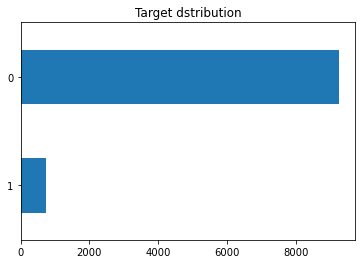

In [55]:
train['churn'].value_counts().sort_index(ascending=False).plot(kind='barh', title = "Target dstribution")

In [13]:
train.to_csv("Basetable_basic_preprocessing.csv")

### Simple train and test - no reduction

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,train.columns != 'churn'], train['churn'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [71]:
# classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Decision tree classifier
def apply_dtree(X_train, X_test, y_train, y_test):
    dtree_model = DecisionTreeClassifier()
    param_grid = {'max_depth': np.arange(3, 10)}
    dtree_gs = GridSearchCV(dtree_model, param_grid, cv=5)
    dtree_model = dtree_gs.fit(X_train, y_train)
    dtree_predictions = dtree_model.predict(X_test)
    dtree_score = dtree_model.score(X_test, y_test)
    roc = roc_auc_score(y_test, dtree_model.predict_proba(X_test)[:,1])
    return dtree_gs, dtree_score,roc

# K Nearest Neighbors Classifier
def apply_knn(X_train, X_test, y_train, y_test):
    print("Type train", type(X_train))
    knn = KNeighborsClassifier()
    params_knn = {'n_neighbors': np.arange(1, 25)}
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    knn = knn_gs.fit(X_train, y_train)
    knn_predictions = knn.predict(X_test)
    knn_score = knn.score(X_test, y_test)
    roc = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
    return knn_gs, knn_score,roc

# Gradient Boosting Classifier
def apply_gbc(X_train, X_test, y_train, y_test):
    gbc_model = GradientBoostingClassifier()
    parameters = {"max_depth":[3,5,8], "n_estimators":[10, 100]}
    gbc_gs = GridSearchCV(gbc_model, parameters, cv=5)
    gbc_model = gbc_gs.fit(X_train, y_train)
    gbc_predictions = gbc_model.predict(X_test)
    gbc_score = gbc_model.score(X_test, y_test)
    roc = roc_auc_score(y_test, gbc_model.predict_proba(X_test)[:,1])
    return gbc_gs, gbc_score,roc

# Random Forest Classifier
def apply_rfc(X_train, X_test, y_train, y_test):
    rfc_model = RandomForestClassifier(oob_score = True) 
    param_grid = {'n_estimators': [50, 100, 200, 400], 'max_features': ['auto', 'sqrt', 'log2']}
    rfc_gs = GridSearchCV(estimator=rfc_model, param_grid=param_grid, cv= 5)
    rfc_model = rfc_gs.fit(X_train, y_train)
    rfc_predictions = rfc_model.predict(X_test)
    roc = roc_auc_score(y_test, rfc_model.predict_proba(X_test)[:,1])
    rfc_score = rfc_model.score(X_test, y_test)
    return rfc_gs, rfc_score, roc

# Linear regression
def apply_logisticRegression(X_train, X_test, y_train, y_test):
    lg =  LogisticRegression()
    lg_model = lg.fit(X_train, y_train)
    lg_predictions = lg_model.predict(X_test)
    roc = roc_auc_score(y_test, lg_model.predict_proba(X_test)[:,1])
    lg_score = lg_model.score(X_test, y_test)
    return lg_model, lg_score, roc

# Naive Bayes
def apply_NB(X_train, X_test, y_train, y_test):
    nb =  BernoulliNB()
    nb_model = nb.fit(X_train, y_train)
    nb_predictions = nb_model.predict(X_test)
    roc = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:,1])
    nb_score = nb_model.score(X_test, y_test)
    return nb_model, nb_score, roc




In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

methods = ['dtree', 'knn', 'gbc', 'rfc','logisticRegression', 'NB']
resulted_models = {}
resulted_scores = list()
roc_vals = list()

cv = KFold(n_splits=10, random_state=1, shuffle=True)

for m in methods:
    this_model, this_score,roc = eval('apply_'+m+'(X_train, X_test, y_train, y_test)')
    resulted_models[m] = this_model
    resulted_scores.append(this_score)
    roc_vals.append(roc)
    scores = cross_val_score(this_model, X_val,y_val, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Model', m, 'with score:', this_score, "ROC", roc, "K FOLD",scores)

Model dtree with score: 0.923 ROC 0.6834908049696782 K FOLD [0.92  0.875 0.93  0.925 0.96  0.89  0.925 0.875 0.94  0.94 ]
Type train <class 'pandas.core.frame.DataFrame'>
Model knn with score: 0.923 ROC 0.5154651686341827 K FOLD [0.93  0.89  0.935 0.93  0.965 0.91  0.93  0.875 0.94  0.94 ]
Model gbc with score: 0.9225 ROC 0.7629412840680446 K FOLD [0.93  0.89  0.93  0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]
Model rfc with score: 0.923 ROC 0.7127713835460315 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model logisticRegression with score: 0.923 ROC 0.5215523912707012 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.94  0.94 ]
Model NB with score: 0.8455 ROC 0.6263384502821123 K FOLD [0.81  0.73  0.845 0.76  0.82  0.83  0.87  0.78  0.84  0.745]


In [20]:
model_chosen = resulted_models['gbc']
model_chosen

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 5, 8], 'n_estimators': [10, 100]})

In [22]:
prediction_test = model_chosen.predict_proba(test)
prediction_test_df = pd.DataFrame(prediction_test)
prediction_test_df

,0,1
0,0.913925,0.086075
1,0.914123,0.085877
2,0.913925,0.086075
3,0.886551,0.113449
4,0.906186,0.093814
...,...,...
9995,0.886551,0.113449
9996,0.956510,0.043490
9997,0.886551,0.113449
9998,0.936001,0.063999


In [25]:
test['predicted'] = prediction_test_df[1]
export_testpredd = test[['cust_id','predicted']]
export_testpredd.to_csv("result_noReduction.csv")

In [ ]:
# de incercat varianta cu smote

### PCA REDUCTION

In [14]:
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
predictors =train.loc[:, train.columns != 'churn'].columns

pca = PCA(n_components=20)
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 0.9999999088426877


In [15]:
print(train_pca.shape)
print(train_pca.shape)

(10000, 20)
(10000, 20)


In [17]:
pd.DataFrame(train_pca).to_csv("Basetable_basic_PCA_dim_reduction.csv")

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_pca, train['churn'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [81]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

methods = ['dtree', 'knn', 'gbc', 'rfc','logisticRegression', 'NB']
resulted_models = {}
resulted_scores = list()
roc_vals = list()

cv = KFold(n_splits=10, random_state=1, shuffle=True)

for m in methods:
    this_model, this_score,roc = eval('apply_'+m+'(X_train, X_test, y_train, y_test)')
    resulted_models[m] = this_model
    resulted_scores.append(this_score)
    roc_vals.append(roc)
    scores = cross_val_score(this_model, X_val,y_val, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Model', m, 'with score:', this_score, "ROC", roc, "K FOLD",scores)

Model dtree with score: 0.9225 ROC 0.56356495617059 K FOLD [0.93  0.88  0.935 0.93  0.965 0.915 0.93  0.875 0.94  0.94 ]
Type train <class 'numpy.ndarray'>
Model knn with score: 0.923 ROC 0.5154651686341827 K FOLD [0.93  0.89  0.935 0.93  0.965 0.91  0.93  0.875 0.94  0.94 ]
Model gbc with score: 0.923 ROC 0.5796316359696642 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.94  0.94 ]
Model rfc with score: 0.9225 ROC 0.5491023061445597 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model logisticRegression with score: 0.45 ROC 0.5959779656962756 K FOLD [0.455 0.565 0.555 0.565 0.575 0.485 0.54  0.475 0.59  0.565]
Model NB with score: 0.923 ROC 0.5959762068916998 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]


### PCA + smote

In [19]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(train_pca, train['churn'])

In [20]:
pd.DataFrame(X, y).to_csv("Basetable_basic_PCA_SMOTE.csv")

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

methods = ['dtree', 'knn', 'gbc', 'rfc','logisticRegression', 'NB']
resulted_models = {}
resulted_scores = list()
roc_vals = list()

cv = KFold(n_splits=10, random_state=1, shuffle=True)

for m in methods:
    this_model, this_score,roc = eval('apply_'+m+'(X_train, X_test, y_train, y_test)')
    resulted_models[m] = this_model
    resulted_scores.append(this_score)
    roc_vals.append(roc)
    scores = cross_val_score(this_model, X_val,y_val, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Model', m, 'with score:', this_score, "ROC", roc, "K FOLD",scores)

Model dtree with score: 0.6540744738262277 ROC 0.7014725048454904 K FOLD [0.66576819 0.61725067 0.64420485 0.57142857 0.61994609 0.63881402
 0.61351351 0.62432432 0.58918919 0.63243243]
Type train <class 'numpy.ndarray'>
Model knn with score: 0.865353480841878 ROC 0.8860677043515488 K FOLD [0.79514825 0.78975741 0.76819407 0.74393531 0.76280323 0.8032345
 0.77027027 0.79189189 0.77567568 0.77567568]
Model gbc with score: 0.8896384241770102 ROC 0.9551643243762751 K FOLD [0.84097035 0.78975741 0.82479784 0.79245283 0.80592992 0.78975741
 0.8027027  0.83513514 0.78378378 0.80540541]
Model rfc with score: 0.9131138694009714 ROC 0.9711661650073319 K FOLD [0.85983827 0.81401617 0.83557951 0.8032345  0.8032345  0.81401617
 0.84594595 0.83783784 0.83513514 0.85405405]


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model logisticRegression with score: 0.5582838640043173 ROC 0.5768657140235991 K FOLD [0.56603774 0.57951482 0.56603774 0.54447439 0.56334232 0.56334232
 0.56216216 0.57297297 0.5972973  0.54054054]
Model NB with score: 0.5693470048569886 ROC 0.5851743284390605 K FOLD [0.54716981 0.56603774 0.56334232 0.54986523 0.54447439 0.52021563
 0.57297297 0.60810811 0.58918919 0.54594595]


### Lasso regression

In [21]:
from sklearn.model_selection import train_test_split

X = train.loc[:, train.columns != 'churn']
y = train['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [22]:
# LASSO REGRESSION
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=1))

In [24]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 114
selected features: 35
features with coefficients shrank to zero: 0


In [59]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index([], dtype='object')

In [25]:
train_filtered  =train[selected_feat]
test_filtered  =test[selected_feat]
# train_filtered_noid = train_filtered.drop(columns='cust_id')
# test_filtered_noid = test_filtered.drop(columns='cust_id')

In [26]:
pd.DataFrame(train_filtered).to_csv("Basetable_basic_LassoSelection.csv")

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_filtered, train['churn'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [74]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

methods = ['dtree', 'knn', 'gbc', 'rfc','logisticRegression', 'NB']
resulted_models = {}
resulted_scores = list()
roc_vals = list()

cv = KFold(n_splits=10, random_state=1, shuffle=True)

for m in methods:
    this_model, this_score,roc = eval('apply_'+m+'(X_train, X_test, y_train, y_test)')
    resulted_models[m] = this_model
    resulted_scores.append(this_score)
    roc_vals.append(roc)
    scores = cross_val_score(this_model, X_val,y_val, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Model', m, 'with score:', this_score, "AUC", roc, "K FOLD",scores)

Model dtree with score: 0.9215 AUC 0.710266845830226 K FOLD [0.93  0.875 0.925 0.925 0.965 0.915 0.925 0.875 0.94  0.94 ]
Type train <class 'pandas.core.frame.DataFrame'>
Model knn with score: 0.923 AUC 0.5433844324689395 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]
Model gbc with score: 0.9225 AUC 0.741307987786861 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.87  0.945 0.94 ]
Model rfc with score: 0.924 AUC 0.6716171152790871 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model logisticRegression with score: 0.923 AUC 0.49945125297237974 K FOLD [0.93  0.89  0.935 0.93  0.965 0.915 0.93  0.875 0.945 0.94 ]
Model NB with score: 0.919 AUC 0.6127516849347835 K FOLD [0.93  0.89  0.93  0.93  0.96  0.915 0.92  0.875 0.94  0.94 ]


### Fisher Score variable selection + SMOTE

In [27]:
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

In [28]:
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['churn']
predictors = [v for v in train.columns if v not in id_var + target_var]

In [29]:
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

,predictor,fisherscore
99,Var126_na,0.271197
41,Var189,0.230800
14,Var73,0.217568
63,Var218,0.196487
1,Var7,0.164765


In [30]:
# Select the top variables based on Fisher Score
# top_fs_vars = fs_df[fs_df['fisherscore'] >= 0.03]['predictor'].values
top_fs_vars = fs_df['predictor'].values[:50]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50


array(['Var126_na', 'Var189', 'Var73', 'Var218', 'Var7', 'Var113',
       'Var207', 'Var65', 'Var13', 'Var193', 'Var144', 'Var229', 'Var210',
       'Var220', 'Var126', 'Var205', 'Var140', 'Var228', 'Var81',
       'Var125', 'Var74', 'Var195', 'Var72', 'Var6', 'Var134', 'Var197',
       'Var28', 'Var200', 'Var221', 'Var119', 'Var109', 'Var112',
       'Var173', 'Var203', 'Var211', 'Var160', 'Var132', 'Var24',
       'Var222', 'Var6_na', 'Var21_na', 'Var81_na', 'Var119_na',
       'Var144_na', 'Var208', 'Var22', 'Var21', 'Var35_na', 'Var132_na',
       'Var22_na'], dtype=object)

In [66]:
train_fisher = train[top_fs_vars]
test_fisher = test[top_fs_vars]

In [67]:

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(train_fisher, train['churn'])

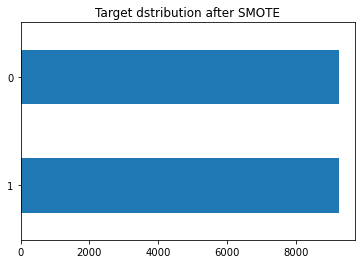

In [68]:
y.value_counts().sort_index(ascending=False).plot(kind='barh', title = "Target dstribution after SMOTE")

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [103]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(train_fisher, train['churn'], test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

methods = ['dtree', 'knn', 'gbc', 'rfc','logisticRegression', 'NB']
resulted_models = {}
resulted_scores = list()
roc_vals = list()

cv = KFold(n_splits=10, random_state=1, shuffle=True)

for m in methods:
    this_model, this_score,roc = eval('apply_'+m+'(X_train, X_test, y_train, y_test)')
    resulted_models[m] = this_model
    resulted_scores.append(this_score)
    roc_vals.append(roc)
    scores = cross_val_score(this_model, X_val,y_val, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Model', m, 'with score:', this_score, "AUC", roc, "K FOLD",scores)

Model dtree with score: 0.8961144090663788 AUC 0.9380340778860701 K FOLD [0.88409704 0.83018868 0.85175202 0.85983827 0.85175202 0.84097035
 0.88378378 0.84054054 0.83243243 0.87567568]
Type train <class 'pandas.core.frame.DataFrame'>
Model knn with score: 0.832164058283864 AUC 0.8322611366188015 K FOLD [0.74663073 0.75202156 0.7574124  0.70889488 0.72506739 0.74393531
 0.71891892 0.76216216 0.77027027 0.7972973 ]
Model gbc with score: 0.9554776038855909 AUC 0.9791239819373514 K FOLD [0.93800539 0.94339623 0.94339623 0.94070081 0.95687332 0.9245283
 0.96756757 0.93513514 0.94054054 0.94054054]
Model rfc with score: 0.956287101996762 AUC 0.9869261315730844 K FOLD [0.9245283  0.94339623 0.94070081 0.93530997 0.9541779  0.9083558
 0.96216216 0.92972973 0.94324324 0.94054054]


C:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model logisticRegression with score: 0.5709660010793308 AUC 0.6003995800332305 K FOLD [0.55795148 0.56873315 0.56873315 0.54716981 0.5902965  0.55525606
 0.55945946 0.57297297 0.56486486 0.57837838]
Model NB with score: 0.7037236913113869 AUC 0.7764017701511967 K FOLD [0.7115903  0.65768194 0.71967655 0.66037736 0.71428571 0.70619946
 0.71081081 0.71891892 0.68378378 0.7       ]


In [221]:
prediction = gbc_model.predict_proba(test)
test['churn'] = prediction
test['cust_id'] = test['cust_id']
filtered = test[['cust_id','churn']]
filtered

,cust_id,churn
0,1,0
1,2,0
2,5,0
3,6,0
4,10,0
...,...,...
9995,19989,0
9996,19992,0
9997,19994,0
9998,19998,0


In [223]:
filtered.to_csv("result15.csv")

In [231]:
# test_filtered['cust_id'] = test['cust_id']
prediction = gbc_model.predict_proba(test)
prediction_df = pd.DataFrame(prediction)
prediction_df

test['prediction'] = prediction_df[1]
filtered = test[['cust_id','prediction']]
filtered.to_csv("result24.csv")

ValueError: Number of features of the model must match the input. Model n_features is 114 and input n_features is 115 